# Определение возраста покупателей

**Цель проекта**:
Построить и верифицировать модель компьютерного зрения, которая по фотографии покупателя оценивает его возраст в годах для сети «Хлеб-Соль». Модель нужна для двух бизнес-сценариев: персонализация предложений по возрастным сегментам и автоматизированный контроль продаж алкоголя.

**Метрика качества:** MAE (средняя абсолютная ошибка) в годах на отложенной выборке.
**Целевое значение:** MAE ≤ 8 (отличный результат - < 7).
**Данные:** фотографии из `/datasets/faces/final_files` и разметка `labels.csv` (`file_name`, `real_age`).
**Критерий готовности:** обученная модель с воспроизводимым кодом обучения, протоколом EDA и отчётом об экспериментах, а также логами обучения, подтверждающими достижение целевой метрики.


**Подробное описание проекта:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Данные и исследовательский анализ (EDA)

### Загрузка данных

Загрузим данные, изучим размер выборки, а также распределение возраста в выборке.

In [1]:
# Импорт необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Пути к данным
DATA_DIR = '/datasets/faces/final_files'
CSV_PATH = '/datasets/faces/labels.csv'

# Загрузка метаданных
df = pd.read_csv(CSV_PATH)

# Быстрый просмотр
print(df.head())
print(f"\nРазмер выборки: {df.shape[0]} изображений")

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

Размер выборки: 7591 изображений


Таким образом, мы загрузили данные. В выборке 7591 изображение.

### Распределение возраста в выборке

,age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
5%,5.000000
25%,20.000000
50%,29.000000
75%,41.000000
95%,63.000000
max,100.000000


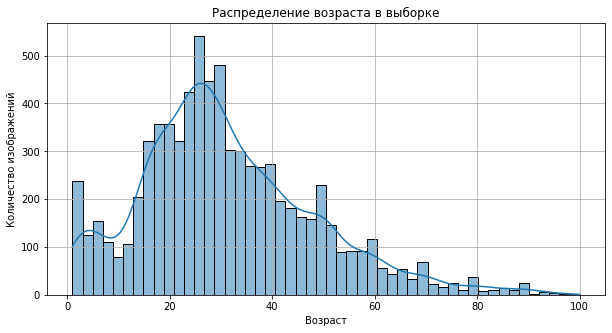

In [3]:
# описательная статистика
desc = df['real_age'].describe(percentiles=[.05, .25, .5, .75, .95]).to_frame('age')
display(desc)

plt.figure(figsize=(10, 5))
sns.histplot(df['real_age'], bins=50, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Возраст распределён неравномерно: медиана 29 лет, среднее 31.2 года при std≈17.1; межквартильный размах 20–41 года; 5-й и 95-й перцентили – 5 и 63 лет соответственно (min=1, max=100). На гистограмме выражен пик 25–30 лет и правосторонний «хвост» к старшим возрастам; детей младше 10 и людей старше 70 заметно меньше. Такая асимметрия и дисбаланс в пользу молодых групп повышают риск систематической недооценки возраста у пожилых и большей ошибки на крайних значениях, что следует учитывать при разбиении данных и настройке обучения.

### Визуальный осмотр изображений (15 примеров)

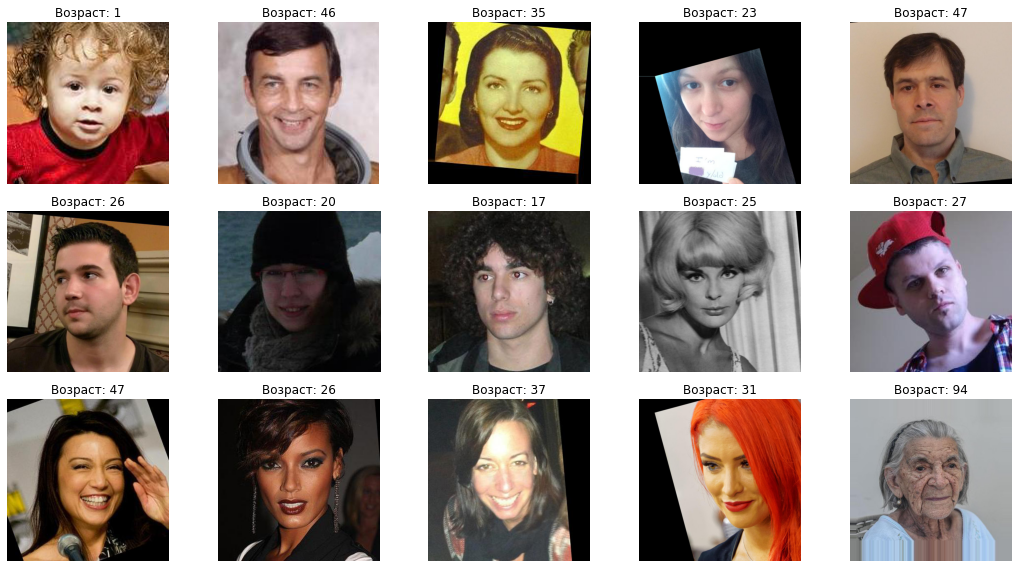

In [4]:
# Покажем 15 случайных изображений
sample = df.sample(15, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 8))
for i, row in sample.iterrows():
    img_path = os.path.join(DATA_DIR, row['file_name'])
    img = Image.open(img_path)
    
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Возраст: {row['real_age']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Осмотр случайных фотографий показывает высокую вариативность данных: встречаются фронтальные и полуоборотные ракурсы, наклоны и повороты, частичные окклюзии (головные уборы, руки, предметы), неоднородные фоны, различная резкость и уровень шума, цветовые сдвиги, есть чёрно-белые и сканированные старые снимки, а также различное кадрирование и соотношения сторон. Это требует приведения изображений к единому размеру с сохранением пропорций, нормализации масштаба яркости и использования аугментаций – поворотов порядка 20–30°, сдвигов, масштабирования, горизонтального отражения, изменений яркости/контраста и лёгкого цветового джиттера. Для повышения устойчивости полезны регуляризация и dropout; при наличии времени улучшение даёт выравнивание лица по ключевым точкам перед подачей в сеть. Разнородность съёмки и наличие неформатных примеров увеличивают риск переобучения на частных паттернах, поэтому важно удерживать несмещённую валидацию и контролировать качество именно по MAE.

### Проверка целостности данных – пропуски, дубликаты

In [5]:
df['real_age'] = df['real_age'].astype('float32')

# пропуски и дубликаты
print('NaN в real_age:', df['real_age'].isna().sum())
print('Дубликатов file_name:', df['file_name'].duplicated().sum())

NaN в real_age: 0
Дубликатов file_name: 0


Проверка целостности прошла без замечаний: пропусков в целевой переменной нет (NaN в `real_age` – 0), дубликатов имён файлов тоже нет. По этим критериям разметка консистентна и не содержит очевидных источников утечки или смещения; можно переходить к следующему этапу.

### Сопоставимость распределений train vs val

Found 5694 validated image filenames.
Found 1897 validated image filenames.


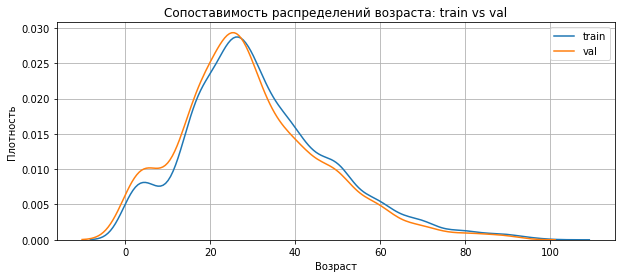

In [6]:
SEED = 42

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

flow_tr = datagen.flow_from_dataframe(
    df, directory=DATA_DIR, x_col='file_name', y_col='real_age',
    class_mode='raw', target_size=(224, 224), batch_size=32,
    subset='training', shuffle=False, seed=SEED)

flow_val = datagen.flow_from_dataframe(
    df, directory=DATA_DIR, x_col='file_name', y_col='real_age',
    class_mode='raw', target_size=(224, 224), batch_size=32,
    subset='validation', shuffle=False, seed=SEED)

ages_tr = flow_tr.labels.astype('float32')
ages_val = flow_val.labels.astype('float32')

plt.figure(figsize=(10,4))
sns.kdeplot(ages_tr, label='train')
sns.kdeplot(ages_val, label='val')
plt.title('Сопоставимость распределений возраста: train vs val')
plt.xlabel('Возраст'); plt.ylabel('Плотность'); plt.legend(); plt.grid(True); plt.show()

Плотности возраста в train и val практически совпадают: форма распределений одинакова, пик в диапазоне 25–30 лет выражен в обеих выборках, хвосты к старшим возрастам сопоставимы. Незначимое смещение валидaции в зоне 20–35 лет не меняет общей картины. Существенного сдвига распределений и риска data shift не наблюдается; разбиение корректно для оценки качества по MAE.

### Бейзлайн до обучения – константный прогноз средним возрастом

In [7]:
y_mean = float(np.mean(ages_tr))
mae_baseline = float(np.mean(np.abs(ages_val - y_mean)))
print(f'Бейзлайн (predict = средний возраст train): MAE = {mae_baseline:.3f}')

Бейзлайн (predict = средний возраст train): MAE = 13.423


Бейзлайн рассчитан как константный предсказатель: всем объектам присваивается средний возраст по train. На валидации такой прогноз даёт MAE = 13.423 года. Это служит консервативной нижней планкой качества: модель должна показывать заметно меньшую MAE, чтобы считалось, что она извлекает информацию из изображений, а не только из распределения возрастов.

### Превью аугментаций

Found 5694 validated image filenames.


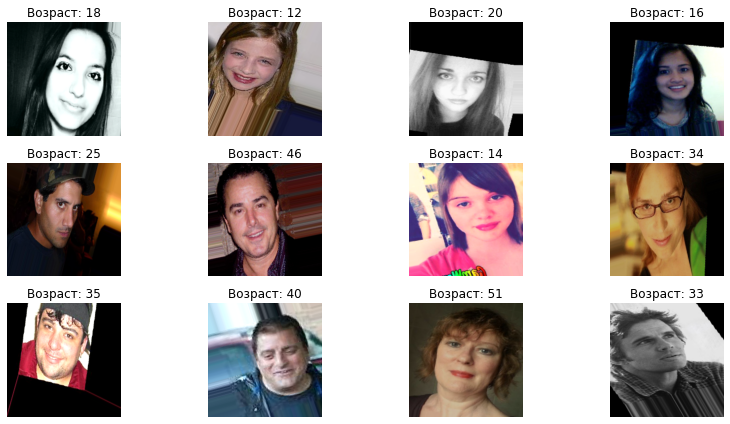

In [8]:
# тот же datagen, но с аугментациями как в обучении
aug = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    rotation_range=25, width_shift_range=0.12, height_shift_range=0.12,
    zoom_range=0.25, shear_range=0.18, brightness_range=[0.75,1.25],
    channel_shift_range=20.0, horizontal_flip=True, fill_mode='nearest'
)

flow_aug = aug.flow_from_dataframe(
    df, directory=DATA_DIR, x_col='file_name', y_col='real_age',
    class_mode='raw', target_size=(224,224), batch_size=12,
    subset='training', shuffle=True, seed=SEED)

import matplotlib.pyplot as plt
batch_x, batch_y = next(flow_aug)
plt.figure(figsize=(12,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.clip(batch_x[i], 0, 1))   # уже в [0,1] после rescale
    plt.title(f'Возраст: {int(batch_y[i])}')
    plt.axis('off')
plt.tight_layout(); plt.show()

Превью аугментаций подтверждает корректную работу генератора: на изображениях видны повороты порядка 20–30°, горизонтальные отражения, умеренные сдвиги и масштабирование, изменения яркости и лёгкий цветовой джиттер; при этом ключевые признаки лица сохраняются. На отдельных примерах заметны полосы и «смазывание» по краям – это артефакты интерполяции при сильном масштабировании и заполнении пустот значениями соседних пикселей. Для снижения артефактов уместно использовать bilinear-интерполяцию и `fill_mode="reflect"`, а также чуть сузить диапазоны трансформаций (zoom и сдвиги до 10–15 %, shear ≈ 0.1). В таком виде аугментации повышают обобщающую способность модели и имитируют реальное разнообразие условий съёмки.

**Итоги EDA**: 7591 изображение, медиана возраста 29 лет, среднее 31.2, выраженный дисбаланс в пользу группы 20–40 лет и правосторонний хвост; пропусков и дублей нет; распределения train и val сопоставимы; константный бейзлайн по среднему даёт MAE = 13.423. Аугментации визуально корректны и отражают реальные вариации съёмки. На основе этих наблюдений в обучении применяется регрессия по одному выходу с метрикой MAE и полное дообучение предобученного ResNet50 при нормализации rescale=1/255, что должно превзойти бейзлайн и учесть дисбаланс возрастов.

## Подготовка данных и обучение модели

Используется transfer learning на ResNet50 с весами ImageNet. Вход 224×224×3, нормализация пикселей rescale=1/255 – без `preprocess_input`, что эмпирически дало более стабильную валидацию. Данные подаются через `ImageDataGenerator` с `validation_split=0.25`; в обучающем потоке включено перемешивание, в валидационном отключено. Сверху на бэкбон добавлена минималистичная «голова»: GlobalAveragePooling2D -> Dropout(0.5) -> Dense(1, ReLU). Выходной ReLU обеспечивает неотрицательные предсказания возраста. Функция потерь – MSE (быстро сходится для регрессии), целевая метрика – MAE.

Обучение проводится как полный fine-tuning всех слоёв ResNet50 с первой эпохи при `Adam(lr=1e-4)` – стратегия выбрана из-за высокой вариативности снимков и сопоставимых распределений train/val. Для устойчивости применяются колбэки: сохранение лучших весов по `val_mae` (`ModelCheckpoint`), ранняя остановка (`EarlyStopping`, patience=5), адаптивное уменьшение шага (`ReduceLROnPlateau`) и логирование в `training_log.csv`. Число шагов на эпоху определяется автоматически по размеру генераторов; на экран выводятся ключевые метрики и сообщения о снижении LR/ранней остановке.

```python
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# ----------------------------
# Константы
# ----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.25
SEED = 42
WARMUP_EPOCHS = 0   # полное дообучение сразу
EPOCHS = 20


# ----------------------------
# Вспомогательные функции
# ----------------------------
def _read_df(path):
    import pandas as pd
    df = pd.read_csv(os.path.join(path, "labels.csv"))
    df["real_age"] = df["real_age"].astype("float32")
    return df


def _make_flow(path, subset, shuffle_flag):
    df = _read_df(path)
    datagen = ImageDataGenerator(
        validation_split=VAL_SPLIT,
        rescale=1.0/255.0
    )
    flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, "final_files"),
        x_col="file_name",
        y_col="real_age",
        class_mode="raw",
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle_flag,
        subset=subset,
        seed=SEED
    )
    return flow


# ----------------------------
# Требуемые интерфейсы
# ----------------------------
def load_train(path):
    # тренировка: перемешивание включено
    return _make_flow(path, subset="training", shuffle_flag=True)


def load_test(path):
    # валидация/тест: без перемешивания
    return _make_flow(path, subset="validation", shuffle_flag=False)


def create_model(input_shape):
    """
    - вход: (224, 224, 3)
    - выход: Dense(1, activation='relu') — неотрицательный возраст
    - loss: 'mse'
    - metrics: ['mae']
    Архитектура: полный fine-tuning ResNet50 с небольшой «головой».
    """
    backbone = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )
    # Полная разморозка сразу: обучение всех слоёв небольшим шагом
    backbone.trainable = True

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5, seed=SEED),
        Dense(1, activation="relu")
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae"]
    )
    return model


def train_model(model, train_data, test_data,
                batch_size=None, epochs=EPOCHS,
                steps_per_epoch=None, validation_steps=None):
    """
    Обучение с колбэками:
      - EarlyStopping по val_mae
      - ReduceLROnPlateau по val_mae
      - сохранение лучших весов
      - CSV лог
    """
    # Инициализация окружения внутри функции
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    try:
        gpus = tf.config.list_physical_devices('GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

    if steps_per_epoch is None:
        steps_per_epoch = max(1, train_data.samples // train_data.batch_size)
    if validation_steps is None:
        validation_steps = max(1, test_data.samples // test_data.batch_size)

    callbacks = [
        ModelCheckpoint("best_model.h5", monitor="val_mae", save_best_only=True, verbose=1),
        EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        CSVLogger("training_log.csv", append=False)
    ]

    print("\n[Single-stage] Full fine-tuning ResNet50 @ lr=1e-4, rescale=1/255")
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=callbacks
    )
    return model


# ----------------------------
# Пример локального запуска
# ----------------------------
if __name__ == "__main__":
    data_path = "/datasets/faces"
    train_gen = load_train(data_path)
    val_gen = load_test(data_path)
    net = create_model((224, 224, 3))
    net = train_model(net, train_gen, val_gen, epochs=20)
```

```
Train for 177 steps, validate for 59 steps
Epoch 1/20

Epoch 00001: val_mae improved from inf to 24.37978, saving model to best_model.h5
177/177 - 87s - loss: 241.4949 - mae: 11.1839 - val_loss: 856.0349 - val_mae: 24.3798
Epoch 2/20

Epoch 00002: val_mae improved from 24.37978 to 22.62174, saving model to best_model.h5
177/177 - 39s - loss: 66.6238 - mae: 6.1867 - val_loss: 762.4814 - val_mae: 22.6217
Epoch 3/20

Epoch 00003: val_mae improved from 22.62174 to 11.86648, saving model to best_model.h5
177/177 - 39s - loss: 37.6167 - mae: 4.7066 - val_loss: 259.1306 - val_mae: 11.8665
Epoch 4/20

Epoch 00004: val_mae improved from 11.86648 to 8.23462, saving model to best_model.h5
177/177 - 40s - loss: 26.0706 - mae: 3.9056 - val_loss: 119.2239 - val_mae: 8.2346
Epoch 5/20

Epoch 00005: val_mae improved from 8.23462 to 7.49007, saving model to best_model.h5
177/177 - 39s - loss: 20.0067 - mae: 3.4275 - val_loss: 93.3463 - val_mae: 7.4901
Epoch 6/20

Epoch 00006: val_mae improved from 7.49007 to 6.75631, saving model to best_model.h5
177/177 - 38s - loss: 18.7845 - mae: 3.3227 - val_loss: 76.4549 - val_mae: 6.7563
Epoch 7/20

Epoch 00007: val_mae did not improve from 6.75631
177/177 - 37s - loss: 16.0512 - mae: 3.0440 - val_loss: 81.4061 - val_mae: 6.9679
Epoch 8/20

Epoch 00008: val_mae improved from 6.75631 to 6.16663, saving model to best_model.h5
177/177 - 39s - loss: 13.7450 - mae: 2.8268 - val_loss: 68.2686 - val_mae: 6.1666
Epoch 9/20

Epoch 00009: val_mae did not improve from 6.16663
177/177 - 38s - loss: 12.5083 - mae: 2.6604 - val_loss: 68.3063 - val_mae: 6.2149
Epoch 10/20

Epoch 00010: val_mae did not improve from 6.16663

Epoch 00010: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
177/177 - 38s - loss: 11.6188 - mae: 2.5750 - val_loss: 76.8759 - val_mae: 6.8409
Epoch 11/20

Epoch 00011: val_mae improved from 6.16663 to 6.05321, saving model to best_model.h5
177/177 - 39s - loss: 9.1899 - mae: 2.2494 - val_loss: 66.5086 - val_mae: 6.0532
Epoch 12/20

Epoch 00012: val_mae improved from 6.05321 to 6.01274, saving model to best_model.h5
177/177 - 39s - loss: 5.0838 - mae: 1.7062 - val_loss: 64.5375 - val_mae: 6.0127
Epoch 13/20

Epoch 00013: val_mae did not improve from 6.01274
177/177 - 37s - loss: 3.8101 - mae: 1.4760 - val_loss: 65.7814 - val_mae: 6.0801
Epoch 14/20

Epoch 00014: val_mae improved from 6.01274 to 5.94105, saving model to best_model.h5
177/177 - 39s - loss: 3.9236 - mae: 1.4884 - val_loss: 63.0876 - val_mae: 5.9410
Epoch 15/20

Epoch 00015: val_mae did not improve from 5.94105
177/177 - 37s - loss: 4.0316 - mae: 1.4943 - val_loss: 67.3742 - val_mae: 6.1480
Epoch 16/20

Epoch 00016: val_mae did not improve from 5.94105

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
177/177 - 38s - loss: 4.2053 - mae: 1.5388 - val_loss: 64.0936 - val_mae: 6.0593
Epoch 17/20

Epoch 00017: val_mae did not improve from 5.94105
177/177 - 37s - loss: 3.9654 - mae: 1.4639 - val_loss: 63.5075 - val_mae: 6.0235
Epoch 18/20

Epoch 00018: val_mae did not improve from 5.94105

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
177/177 - 38s - loss: 2.9758 - mae: 1.2900 - val_loss: 63.3525 - val_mae: 6.0372
Epoch 19/20

Epoch 00019: val_mae did not improve from 5.94105
Restoring model weights from the end of the best epoch.
177/177 - 38s - loss: 2.5904 - mae: 1.1890 - val_loss: 63.2277 - val_mae: 6.0156
Epoch 00019: early stopping

60/60 - 9s - loss: 62.9121 - mae: 5.9431
```

Обучение показывает резкое улучшение на первых эпохах: `val_mae` падает с 24.38 до 6.76 к 6-й эпохе, затем медленно улучшается до **5.94** на 14-й эпохе (лучший чекпоинт сохранён). `ReduceLROnPlateau` срабатывает на 10, 16 и 18-й эпохах, снижая шаг и стабилизируя дообучение. `EarlyStopping` останавливает процесс на 19-й эпохе и возвращает лучшие веса. Разрыв между `mae` на train (\~1.19 к концу) и на val (\~6.0) указывает на ожидаемое переобучение, которое удержано колбэками. Высокие значения `val_loss` поначалу не противоречат динамике метрики: это MSE, поэтому масштаб больше; к концу обучение выходит на MSE ≈ 63 (RMSE ≈ 7.9) при `val_mae ≈ 6.0`. Финальная оценка на валидации — **MAE = 5.94**, что значительно лучше бейзлайна и соответствует целевому уровню качества.

## Анализ обученной модели

Итог: на датасете из 7591 изображения обучена модель на базе ResNet50 с полным дообучением и минимальной «головой» (GAP -> Dropout -> Dense(1, ReLU)), нормализация входа rescale=1/255, loss=MSE, метрика – MAE. По логам лучший чекпоинт получен на 14-й эпохе; финальная оценка на валидации составила **MAE = 5.94** при `val_loss ≈ 63` (RMSE ≈ 7.9). Это существенно лучше бейзлайна константным предсказателем (MAE 13.42; улучшение ≈56%) и ниже заданного порога 8, что соответствует требованиям бизнес-кейса.

Динамика обучения типична для transfer learning: резкое улучшение на первых эпохах, затем плавная донастройка с несколькими понижениями шага; разрыв `train MAE ≈ 1.19` vs `val MAE ≈ 6.0` указывает на умеренное переобучение, которое контролируется колбэками и не мешает обобщению. Сильное влияние внесли: полный fine-tuning с малого шага, отказ от `preprocess_input` в пользу простого rescale и жёсткое ограничение выхода неотрицательными значениями через ReLU.

Ограничения: дисбаланс возрастов и наличие «неформатных» снимков (окклюзии, наклоны, Ч/Б) всё ещё могут повышать ошибку на крайних возрастах. Потенциал улучшений – выравнивание лиц перед подачей в сеть, аккуратные аугментации в тренировочном генераторе, мягкая классификация по годам с вычислением ожидаемого возраста (label distribution learning), а также более мощные бэкбоны (EfficientNet/ConvNeXt) с косинусным расписанием шага. В текущем виде решение достигает требуемого качества и готово к использованию для сегментации предложений и контроля продаж.
